# Settings and imports

#### Imports

In [14]:
import bioframe as bf # Genomic intervals operations
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gseapy as gp # GO enrichment
from gseapy import barplot, dotplot
print(f'{gp.__version__=}')

from ../my_polycomb_utils.my_polycomb_utils import START_FLANK, END_FLANK
from ../my_polycomb_utils.my_polycomb_utils import get_tss_start, get_tss_end, get_genes_list

gp.__version__='1.1.1'


#### Preparing font

In [3]:
from pathlib import Path
from matplotlib import font_manager

# Downloaded in 01_Polycomb_loops_on_HiC_maps.ipynb
fpath=Path("../fonts/Montserrat-Regular.ttf")
fe = font_manager.FontEntry(fname=fpath, name='Montserrat')
font_manager.fontManager.ttflist.insert(0, fe) # or append is fine
font_manager.fontManager.addfont(fpath)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Montserrat']

#### Settings

In [4]:
# Set-up suppression of some varnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# 01: Genes within Polycomb loops

**Figures in thesis:**
- `Figure 6`: (I) Genes counts, (II) GO enrichment

In [5]:
polycomb_anchors = pd.read_table('data/polycomb_dot_anchors.hand_made.bed', 
                          names=['chrom', 'start', 'end', 'genes'], na_values='-')

### _01 (I) Genes counts

In [6]:
# Get GENCODE annotation
gff_colnames = ('chrom', 'DB', 'type', 'start', 'end', '_', 'strand', '__', 'data')
annotation = pd.read_csv('https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_44/gencode.v44.annotation.gff3.gz', 
                         sep='\t', header=None, comment='#', names=gff_colnames)
annotation['gene_name'] = annotation['data'].str.extract(r'gene_name=([^;]+)', expand=False)
annotation['gene_type'] = annotation['data'].str.extract(r'gene_type=([^;]+)', expand=False)
annotation = annotation[['chrom', 'start', 'end', 'gene_name', 'gene_type', 'strand', 'type']]

In [7]:
annotation.head(3)

,chrom,start,end,gene_name,gene_type,strand,type
0,chr1,11869,14409,DDX11L2,lncRNA,+,gene
1,chr1,11869,14409,DDX11L2,lncRNA,+,transcript
2,chr1,11869,12227,DDX11L2,lncRNA,+,exon


In [9]:
# Extract regions around genes promoters
promoters = annotation.query('type=="gene"').copy()
promoters['start'] = promoters.apply(get_tss_start, axis=1)
promoters['end'] = promoters.apply(get_tss_end, axis=1)
promoters = promoters[['chrom', 'start', 'end', 'gene_type', 'gene_name']]

# Assing genes to loops
polycomb_anchors_anno = bf.overlap(polycomb_anchors, promoters, how='left', suffixes=('','_anno'))
polycomb_anchors_anno = polycomb_anchors_anno.groupby(['chrom', 'start', 'end']).agg({'gene_name_anno': get_genes_list}).reset_index()
polycomb_anchors_anno['n_genes'] = polycomb_anchors_anno['gene_name_anno'].apply(lambda x: len(x))

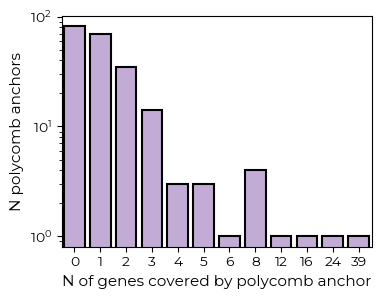

In [10]:
fig = plt.figure(figsize=(4, 3), dpi=100)

sns.barplot(polycomb_anchors_anno.n_genes.value_counts().to_frame().reset_index(),
            x='n_genes', y='count',
            edgecolor="black", facecolor='#c2acd5',
            linewidth=1.5, 
           )

plt.yscale('log')
plt.xlabel('N of genes covered by polycomb anchor', fontsize=11)
plt.ylabel('N polycomb anchors', fontsize=11);

### _02 (I) GO enrichment

In [11]:
# Prepare genes for GO
genes = sum([[genes] if (',' not in str(genes)) else genes.split(',') for genes in polycomb_anchors.genes.tolist() ], [])
genes = [gene for gene in genes if str(gene) != 'nan']

# Prepare Background for GO
## Background - Genes expressed in neurons
## From Rizzardi 2019 Nat Naurosc
background = pd.read_table('data/rnaseq.rizzardi2019.counts.GENCODE.autosomes_and_chrX.with_meta.tsv.gz',
                            usecols=[0,1,2,3])
background = background[background["gene.type"] == "protein_coding"]['gene.name'].unique().tolist()

In [12]:
# Run Go
enr = gp.enrichr(gene_list=genes,
                 background=background,
                 gene_sets=['GO_Biological_Process_2021',
                            'GO_Cellular_Component_2021',
                            'GO_Molecular_Function_2021'],
                 organism='Human',
                 outdir=None, 
                )

# Prettify the results
enr.results[['Term', 'GO_cat']] = enr.results.Term.str.removesuffix(')').str.split('\(GO:', expand=True)
enr.results['Gene_set_short'] = enr.results['Gene_set'].str.removesuffix('_2021')\
                                   .str.removeprefix('GO_')\
                                   .apply(lambda x: x.split('_')[0][0] + x.split('_')[1][0])

([], [])

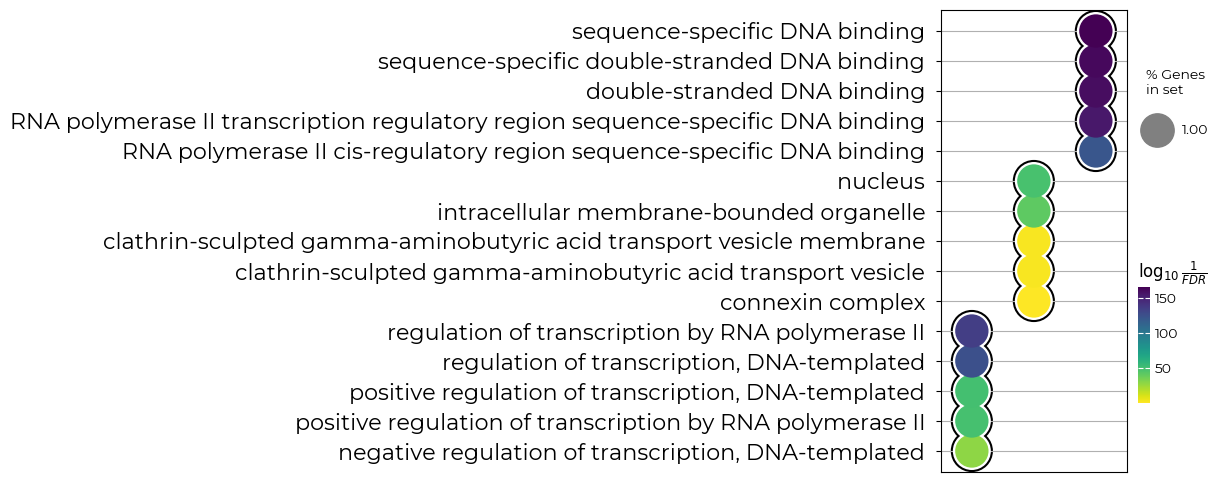

In [13]:
ax = dotplot(enr.results,
              column="Adjusted P-value",
              x='Gene_set_short',
              size=4,
              top_term=5,
              figsize=(3,6),
              title = "",
              show_ring=True,
              marker='o',
             )
plt.xlabel('')
plt.title('')
plt.xticks([], [])
